In [1]:
import os
import re
from sparta.Auxil.PeriodicityDetector import PeriodicityDetector
from sparta.UNICOR.Spectrum import Spectrum
from sparta.UNICOR.Template import Template
from sparta.Auxil.TimeSeries import TimeSeries
from sparta.Observations import Observations
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, peak_prominences
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import sparta.Statistics as stat


Bad key text.latex.preview in file c:\Users\kentb\miniconda3\envs\pdm\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.4/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file c:\Users\kentb\miniconda3\envs\pdm\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.4/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file c:\Users\kentb\miniconda3\envs\pdm\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when

In [2]:
ASAS_results = []
BGCru_results = []
QZNor_results = []
RCru_results = []
V0391_results = []
V1048Cen_results = []
V1210Cen_results = []
zetGem_results = []

for filename in os.listdir('./results/ASASJ103158-5814.7/'):
    ASAS_results.append(stat.open_csv('./results/ASASJ103158-5814.7/'+filename))
for filename in os.listdir('./results/BGCru/'):
    BGCru_results.append(stat.open_csv('./results/BGCru/'+filename))
for filename in os.listdir('./results/QZNor/'):
    QZNor_results.append(stat.open_csv('./results/QZNor/'+filename))
for filename in os.listdir('./results/RCru/'):
    RCru_results.append(stat.open_csv('./results/RCru/'+filename))
for filename in os.listdir('./results/V0391/'):
    V0391_results.append(stat.open_csv('./results/V0391/'+filename))
for filename in os.listdir('./results/V1048Cen/'):
    V1048Cen_results.append(stat.open_csv('./results/V1048Cen/'+filename))
for filename in os.listdir('./results/V1210Cen/'):
    V1210Cen_results.append(stat.open_csv('./results/V1210Cen/'+filename))
for filename in os.listdir('./results/zetGem/'):
    zetGem_results.append(stat.open_csv('./results/zetGem/'+filename))

In [3]:
plt.style.use('sparta')

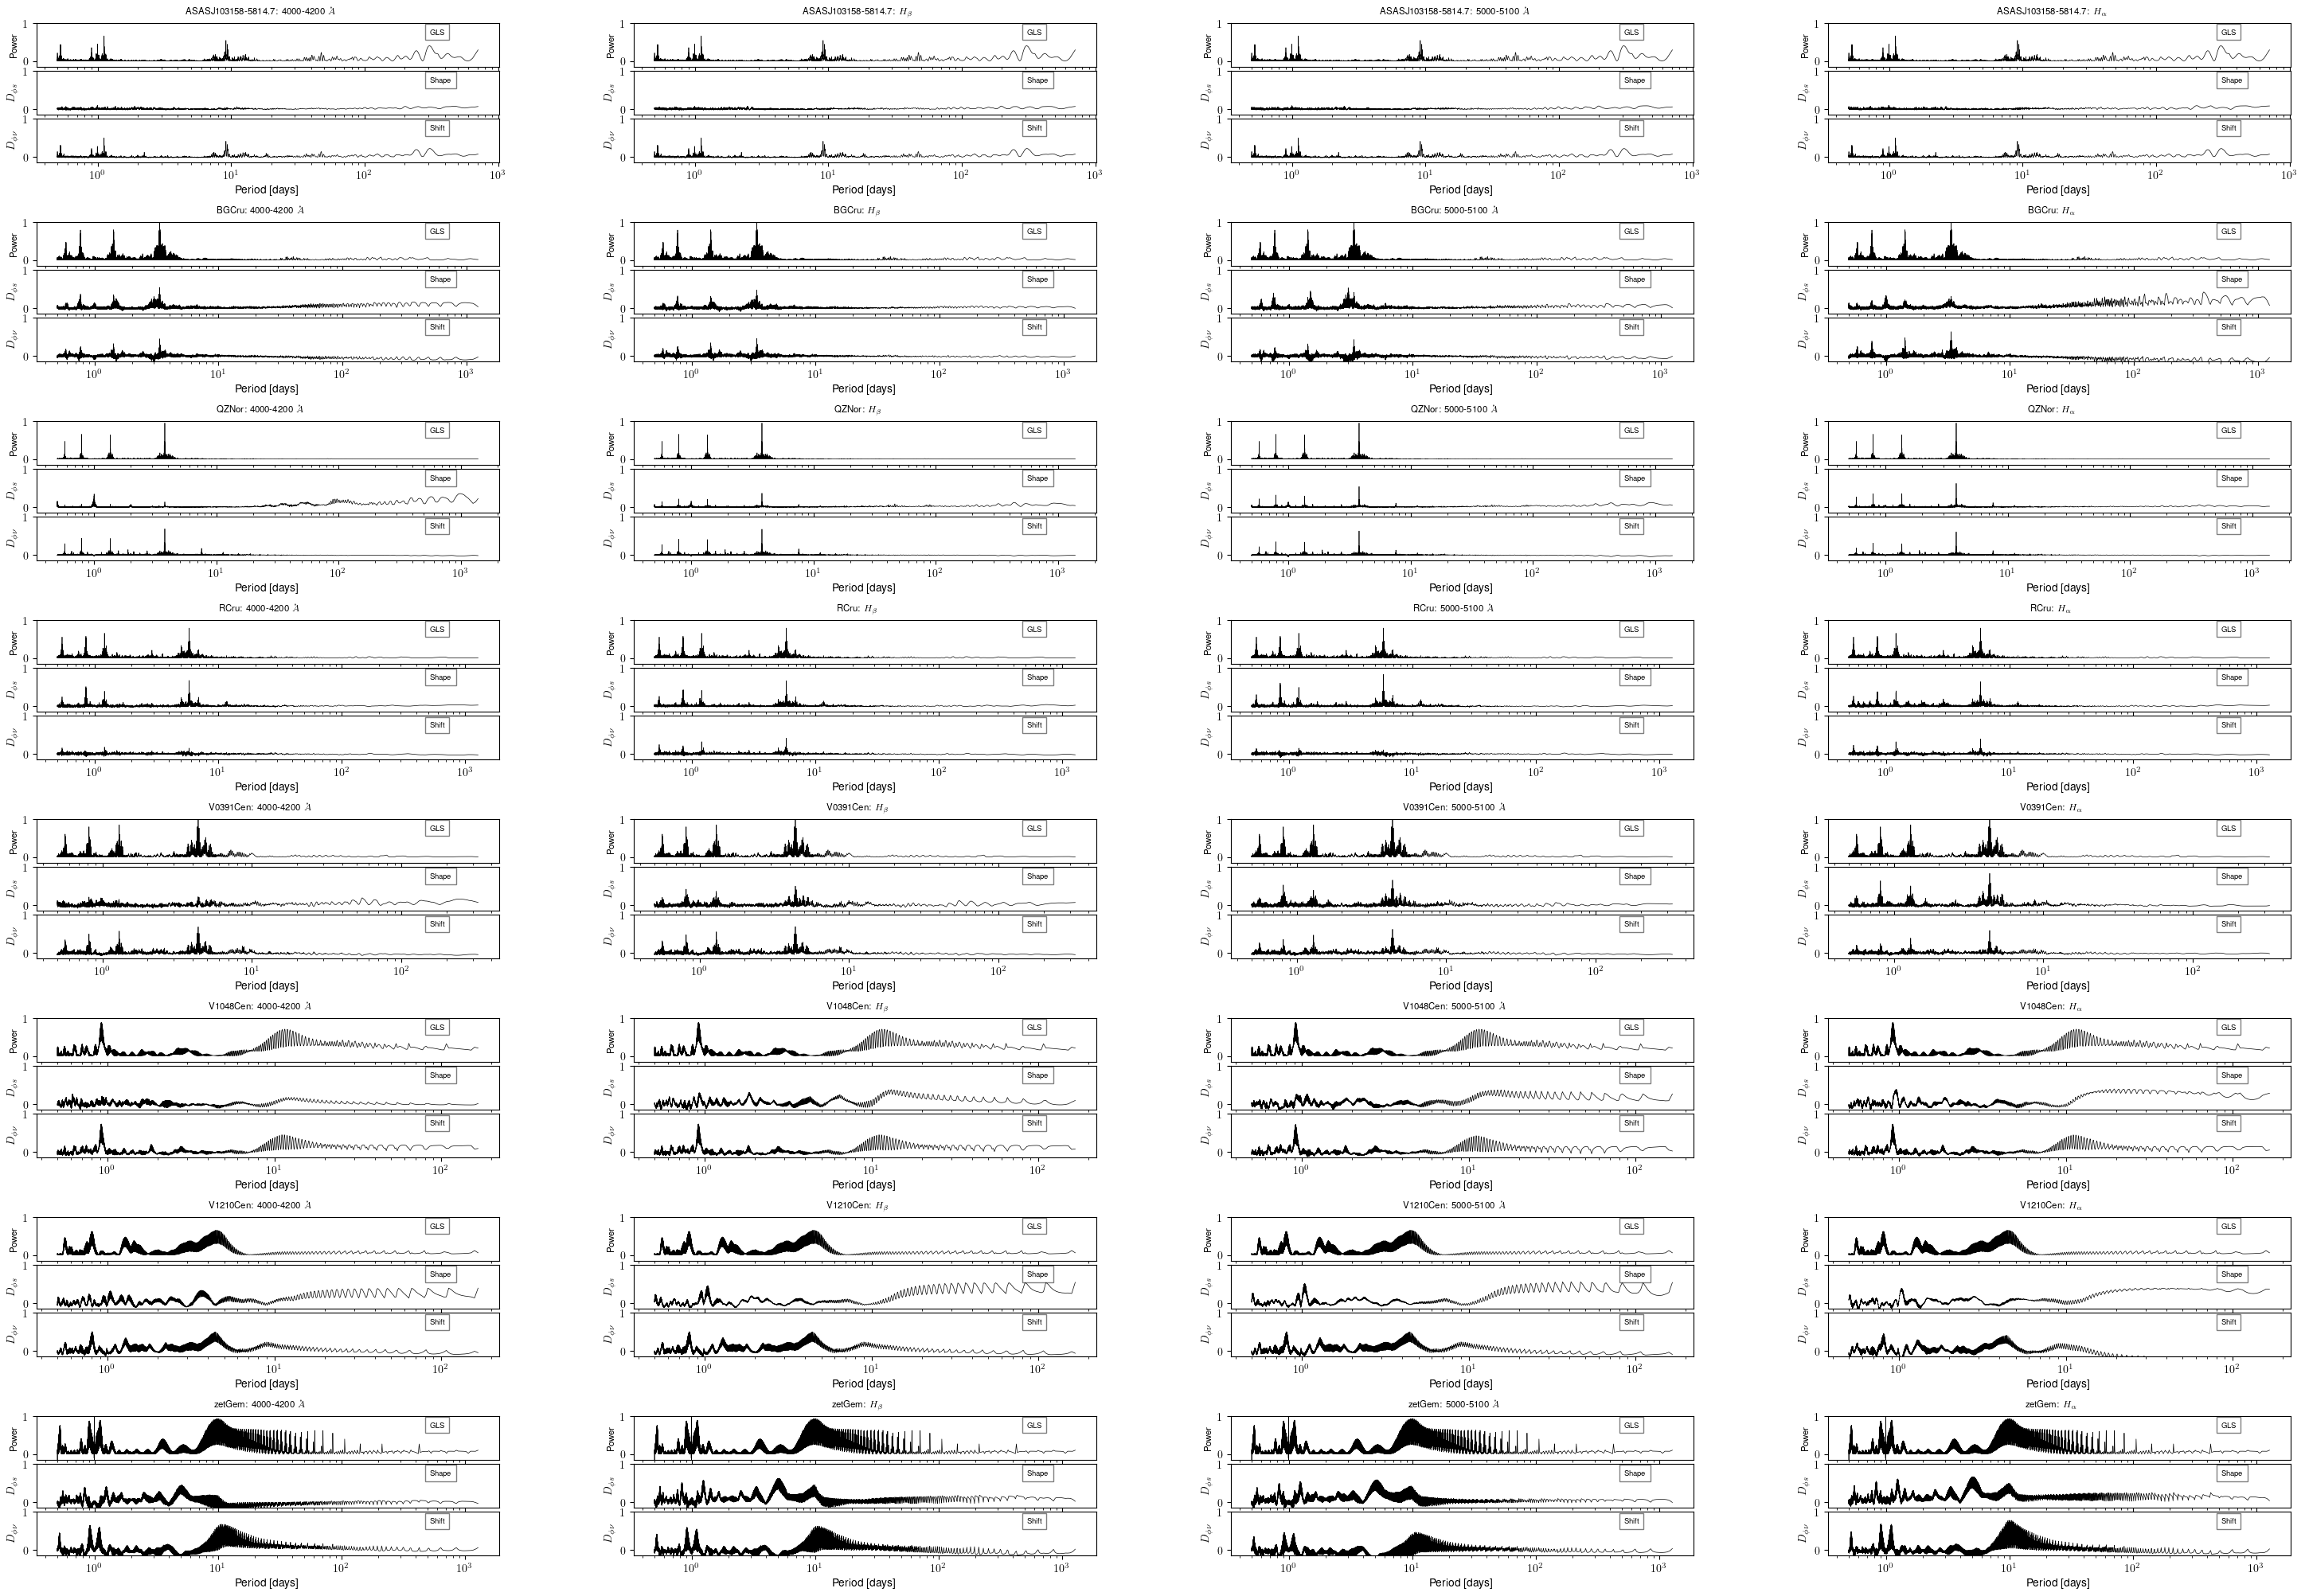

In [4]:
range_size = [r'4000-4200 $\AA$',r'$H_{\beta}$',r'5000-5100 $\AA$',r'$H_{\alpha}$']
all_results = [ASAS_results,BGCru_results, QZNor_results, RCru_results, V0391_results, V1048Cen_results,V1210Cen_results ,zetGem_results]
fig = plt.figure(constrained_layout=False, figsize=(30, 20))
fig.suptitle(r'Coralie14 stars')

subfigs = fig.subfigures(8, 4)
for outerind, subfig in enumerate(subfigs.flat):
    if 0<=outerind<=3:
        results = all_results[0]
        star = r'ASASJ103158-5814.7'
    elif 4<=outerind<=7:
        results = all_results[1]
        star = r'BGCru'
    elif 8<=outerind<=11:
        results = all_results[2]
        star = r'QZNor'
    elif 12<=outerind<=15:
        results = all_results[3]
        star = r'RCru'
    elif 16<=outerind<=19:
        results = all_results[4]
        star = r'V0391Cen'
    elif 20<=outerind<=23:
        results = all_results[5]
        star = r'V1048Cen'
    elif 24<=outerind<=27:
        results = all_results[6]
        star = r'V1210Cen'
    elif 28<=outerind<=31:
        results = all_results[7]
        star = r'zetGem'
    axs = subfig.subplots(3,1,sharex=True,sharey = True)
    subfig.suptitle(star+': ' +str(range_size[outerind%4]), fontsize='small')
    for innerind, ax in enumerate(axs.flat):
        #put semilog(x)
        if innerind==0:
            ax.plot(results[outerind%4]['period'], results[outerind%4]['gls'],linewidth=0.5)
            ax.set_xscale('log')
            ax.set_ylabel('Power', fontsize='small')
        elif innerind==1:
            ax.plot(results[outerind%4]['period'], results[outerind%4]['shape'],linewidth=0.5)
            ax.set_xscale('log')
            ax.set_ylabel(r'$D_{\phi s}$')
        elif innerind==2:
            ax.plot(results[outerind%4]['period'],results[outerind%4]['shift'],linewidth=0.5)
            ax.set_xscale('log')
            ax.set_ylabel(r'$D_{\phi \nu}$')
            ax.set_xlabel(r'Period [days]')
        ax.set_ylim(-0.15,1)
        text_box = f"{['GLS', 'Shape', 'Shift'][innerind]}"
        ax.text(0.85, 0.75, text_box, transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5),fontsize = 'x-small')
plt.subplots_adjust(top=0.9, hspace=0.1, wspace=0.2,bottom=0.2)
plt.savefig('all_coralie14.pdf')
plt.show()